In [1]:
from scipy.integrate import odeint
import numpy as np
import yaml
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy as copy
from model import Data, ode_objective, ode_solve, eval_grads, precompile_model, rungekutta4
import sciris as sc

with open("tb-mbr/paramteres.yml", "r", encoding="utf8") as file:
    p = yaml.safe_load(file)

def output(string: str):
    with open("output.txt", "a") as file:
        file.write(string + "\n")


n=3 #number of various initial states

initial_state = p["initial_state"]
# for key in initial_state.keys():
#     #for i, val in enumerate(initial_state[key]):
        # initial_state[key] = [initial_state[key]]*n
params = p["default_params"]

# for key in params.keys():
#     params[key] = np.array([i/n*params[key] for i in range(1,n+1)])
# print(initial_state)
t_start = 2009
modelling_time = 10
t_end = t_start + modelling_time

step = 1/120

times_to_save = list(range(1,modelling_time+1))
steps_to_save = np.array(times_to_save)/step

model_kwargs = {
    "initial_state": initial_state,
    "t_start": t_start,
    "t_end": t_end,
    "step":step,
    "steps_to_save":steps_to_save,
} | p["model_kwargs"]

equation_strings, custom_vars = precompile_model(model_kwargs['equation_strings'], model_kwargs['custom_vars'])
model_kwargs['equation_strings'] = equation_strings
model_kwargs['custom_vars'] = custom_vars
'''
def ode_model_wrapped(x,t,args):
    params, equation_strings, custom_vars, multistart = args
    system_state = dict(zip(equation_strings.keys(), x))
    return ode_model(equation_strings, system_state, params, t, custom_vars, multistart)
'''

def scipy_solver(func, init_x: dict, t_end: float, step: float, t_start=0, steps_to_save=None, func_args=()):
    ## input :
    # func(parameters, x_values) - function discribes the model
    # param - system parameters

    # init_x - initial system values
    # t_start - time of start, where initial is set
    # t_end - ending
    # step - grid step
    ## output :
    # result - system vaue on grid of time points
    # result - system vaue on grid of time points
    T = t_end - t_start
    Nt = int(T / step)
    if steps_to_save is None:
        steps_to_save = list(range(1,Nt))
    if Nt<0:
        step = -step
        Nt = -Nt
        warnings.warn('RK4: Check the step direction and start/end times. Automaticaly reversed step direction.')
        #raise Error('Wrong step direction')
        
    val_temp = np.array(list(init_x.values()))
    keys = init_x.keys()
    
    #func(x=val_temp, t=t_start+j * step, args=func_args)[:,0]
        
    
    result = odeint(func, val_temp, np.linspace(t_start, t_end, Nt), args=func_args)
    
    # result = np.empty((len(steps_to_save), *(np.array(list(init_x.values())).shape)))
    # current_state = copy.copy(np.asarray(list(init_val_temp.values())))
    # i=0
    # for j in range(1, Nt + 1):
    #     current_state = make_step(current_state, func=func)
    #     if j == steps_to_save[i]:
    #          result[i] = copy.copy(current_state)
    #          i += 1
    #          try:
    #                steps_to_save[i]
    #          except:
    #                break
    return result


In [2]:
results = ode_solve(params=params, solver=rungekutta4, **model_kwargs)

In [3]:
results = ode_solve(params=params, **model_kwargs)

In [4]:
results

Data(keys=array(['S', 'Es', 'Eg', 'Is', 'Ig', 'EsT', 'EgT', 'IsT', 'IgT'],
      dtype='<U3'), points=array([[2009.        , 2009.00500179, 2009.01000357, ..., 2022.98999643,
        2022.99499821, 2023.        ],
       [2009.        , 2009.00500179, 2009.01000357, ..., 2022.98999643,
        2022.99499821, 2023.        ],
       [2009.        , 2009.00500179, 2009.01000357, ..., 2022.98999643,
        2022.99499821, 2023.        ],
       ...,
       [2009.        , 2009.00500179, 2009.01000357, ..., 2022.98999643,
        2022.99499821, 2023.        ],
       [2009.        , 2009.00500179, 2009.01000357, ..., 2022.98999643,
        2022.99499821, 2023.        ],
       [2009.        , 2009.00500179, 2009.01000357, ..., 2022.98999643,
        2022.99499821, 2023.        ]]), data=array([[1.00000000e+06, 3.00000000e+03, 1.00000000e+02, ...,
        1.00000000e+01, 5.00000000e+02, 2.50000000e+01],
       [9.99988692e+05, 2.99855002e+03, 1.00261645e+02, ...,
        1.00579036e+01, 4.99

In [4]:
import time
tst = time.time()
for i in range(3000):
    ode_solve(params=params, solver=scipy_solver, **model_kwargs)
print(time.time() - tst)

20.46666193008423


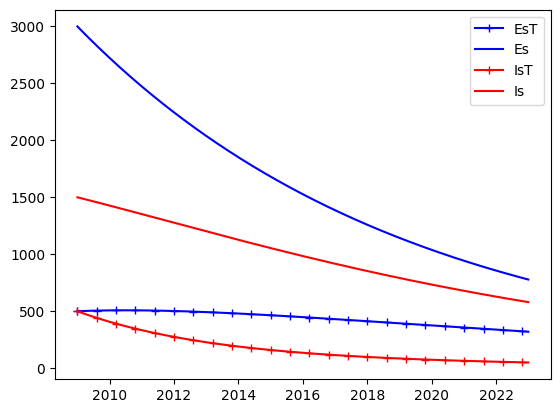

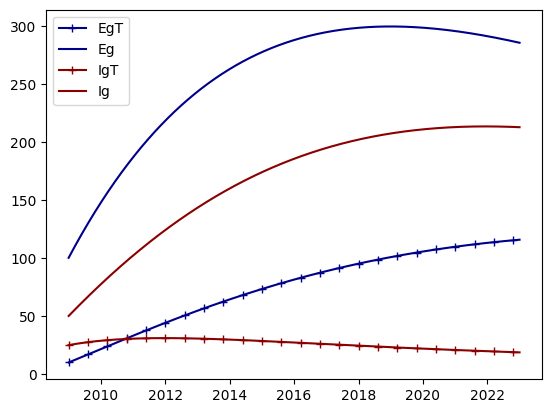

In [5]:
def plotting(key):
    c='blue'
    m=''
    if 'T' in key:
        m='+'
    if 'I' in key:
        c='red'
    if 'g' in key:
        c = 'dark'+c
    plt.plot(results[key].points, results[key].data, label=key,marker=m,markevery=120,c=c)

for key in ['EsT','Es', 'IsT', 'Is']:#key = 's'
    plotting(key)
plt.legend()
#plt.yscale('log')
plt.show()

for key in ['EgT','Eg', 'IgT', 'Ig']:#key = 's'
    plotting(key)
plt.legend()
#plt.yscale('log')
plt.show()